In [3]:
import os
import sys

os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [4]:
## Create SparkContext, SparkSession
from os.path import expanduser, join, abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location points to the default location for managed databases and tables
warehouse_location = 'hdfs:///apps/hive/warehouse/'

spark = SparkSession \
    .builder \
    .appName("Machine Learning Example using Spark ML") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

In [5]:
spark

In [64]:
#Define Schema
from pyspark.sql.types import *
from pyspark.sql.functions import *

uberDataSchema = StructType([
    StructField("DateTime", StringType(), True),
    StructField("Latitude", StringType(), True),
    StructField("Longitude", StringType(), True),
    StructField("CompanyId", StringType(), True),
])

In [65]:
uberDf = spark.read.format("csv")\
.option("header","false")\
.option("inferSchema","true")\
.load("hdfs://bigdata:8020/user/2573B55/UberData", schema=uberDataSchema)

In [66]:
#hdfs dfs -cat hdfs://bigdata:8020/user/2573B55/UberData/* | wc -l
#uberDf
uberDf

DataFrame[DateTime: string, Latitude: string, Longitude: string, CompanyId: string]

In [69]:
uberDf.createOrReplaceTempView("uberDataTable")
spark.sql('select count(*) from uberDataTable where Latitude is NULL or Longitude is NULL').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [68]:
## Replace NULL values with zeroes
from pyspark.sql.functions import when
uberDf = uberDf.withColumn('Latitude', when(uberDf.Latitude.isNotNull(), 
                                           uberDf.Latitude).otherwise(0))
uberDf = uberDf.withColumn('Longitude', when(uberDf.Longitude.isNotNull(), 
                                           uberDf.Longitude).otherwise(0))
#df = df.na.drop()
#df.show()
#zeroBalance = uberDf.where(uberDf.Longitude < 0)
#zeroBalance.count()

In [23]:
#uberDf = uberDf.withColumnRenamed('_c0','DateTime')
#uberDf = uberDf.withColumnRenamed('_c1','Latitude')
#uberDf = uberDf.withColumnRenamed('_c2','Longitude')
#uberDf = uberDf.withColumnRenamed('_c3','CompanyId')

In [70]:
(trainingData, sampleData) = uberDf.randomSplit([0.8, 0.2])

In [90]:
sampleData = sampleData.selectExpr("cast(Latitude as double) Latitude", 
                        "cast(Longitude as double) Longitude")
trainingData = trainingData.selectExpr("cast(Latitude as double) Latitude", 
                        "cast(Longitude as double) Longitude")
sampleData = sampleData.na.drop()
trainingData = trainingData.na.drop()

In [76]:
sampleData

DataFrame[Latitude: double, Longitude: double]

In [88]:
sampleData.createOrReplaceTempView("sampleDataTable")
spark.sql('select count(*) from sampleDataTable where Latitude is NULL or Longitude is NULL').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [77]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['Latitude', 'Longitude'],
                            outputCol='num_features_all')

In [78]:
from pyspark.ml.feature import MinMaxScaler
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", 
                                      outputCol = "scaled_num_features")

In [79]:
from pyspark.ml import Pipeline
preprocessiong_Stages = [assembler] +\
                        [min_Max_Scalar_NumVars]

new_data_mod = Pipeline(stages=preprocessiong_Stages)
new_data_trnfm = new_data_mod.fit(sampleData)
new_data = new_data_trnfm.transform(sampleData)

In [80]:
features = new_data.select("num_features_all")

In [105]:
new_data.show()

+--------+---------+
|Latitude|Longitude|
+--------+---------+
| 40.7116| -73.9531|
| 40.7254| -74.0001|
| 40.7502| -73.9944|
| 40.7103| -73.9634|
| 40.7604| -73.9706|
| 40.7699| -73.8638|
| 40.7172| -73.8467|
| 40.8001| -73.9716|
| 40.8876| -73.9088|
| 40.7221| -73.9839|
| 40.7541| -73.9736|
|  40.735| -74.0003|
| 40.7567| -73.9786|
| 40.7488| -74.0021|
| 40.7687| -73.8628|
| 40.7387| -74.0091|
| 40.7217| -73.9934|
| 40.6375|  -73.903|
| 40.6894| -73.9706|
| 40.6978| -73.9942|
+--------+---------+
only showing top 20 rows



In [82]:
#Just like that-no relevance block
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
kmeans = KMeans(featuresCol='scaled_num_features', k=2, seed=1)
model = kmeans.fit(new_data)
centers = model.clusterCenters()
len(centers)

model.computeCost(new_data)

0.5863960799532042

In [83]:
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_num_features")
    model = kmeans.fit(new_data.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(new_data) # requires Spark 2.0 or later

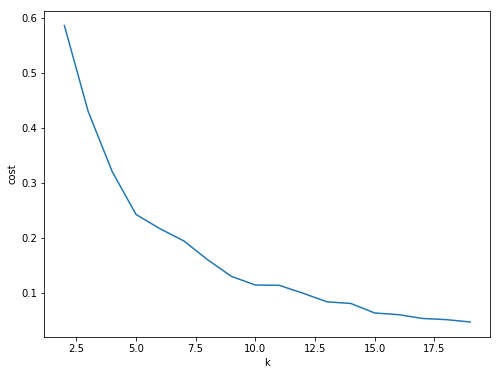

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
#Look like there is very little gain after k=10, so we stick to that choice when processing the full data set.

### Train the machine learning model

In [155]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol='scaled_num_features', k=10, seed=1)

kmeans_Pipeline = Pipeline(stages=preprocessiong_Stages+[kmeans])
#kmeans_Pipeline_model = kmeans_Pipeline.fit(sampleData)
kmeans_Pipeline_model = kmeans_Pipeline.fit(trainingData)

kmeans_Pipeline_model.transform(sampleData).show(5)

+--------+---------+------------------+--------------------+----------+
|Latitude|Longitude|  num_features_all| scaled_num_features|prediction|
+--------+---------+------------------+--------------------+----------+
| 40.7116| -73.9531|[40.7116,-73.9531]|[0.62615768226074...|         9|
| 40.7254| -74.0001|[40.7254,-74.0001]|[0.63435051056756...|         9|
| 40.7502| -73.9944|[40.7502,-73.9944]|[0.64907385419140...|         0|
| 40.7103| -73.9634|[40.7103,-73.9634]|[0.62538589408691...|         9|
| 40.7604| -73.9706|[40.7604,-73.9706]|[0.65512942293991...|         0|
+--------+---------+------------------+--------------------+----------+
only showing top 5 rows



In [156]:
#Printing Clusters
kmeans_Pipeline_model.stages[-1].clusterCenters()

[array([0.65679832, 0.33789608]),
 array([0.655792  , 0.38037398]),
 array([0.59121169, 0.41700129]),
 array([0.33271669, 0.30616807]),
 array([0.59330555, 0.16090715]),
 array([0.60612331, 0.34153338]),
 array([0.70327182, 0.3552458 ]),
 array([0.73237852, 0.49696606]),
 array([0.62135337, 0.25556115]),
 array([0.63578551, 0.33060959])]

In [99]:
from pyspark.ml.clustering import KMeans
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_num_features")
model = kmeans.fit(new_data)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.65679832 0.33789608]
[0.655792   0.38037398]
[0.59121169 0.41700129]
[0.33271669 0.30616807]
[0.59330555 0.16090715]
[0.60612331 0.34153338]
[0.70327182 0.3552458 ]
[0.73237852 0.49696606]
[0.62135337 0.25556115]
[0.63578551 0.33060959]


In [91]:
from pyspark.ml import Pipeline
preprocessiong_Stages = [assembler] +\
                        [min_Max_Scalar_NumVars]

new_data_mod = Pipeline(stages=preprocessiong_Stages)
new_data_trnfm = new_data_mod.fit(trainingData)
new_data = new_data_trnfm.transform(trainingData)

In [157]:
kmeans_Pipeline_model.write().overwrite().save('file:////home/2573B55/uberModel')

# Creating Consumer

In [ ]:
# Create __SparkSession__ object
# 
#     The entry point to programming Spark with the Dataset and DataFrame API.
# 
#     Used to create DataFrame, register DataFrame as tables and execute SQL over tables etc.

from pyspark.sql import SparkSession

# Import the necessary classes and create a local SparkSession, the starting point of all functionalities related to Spark.
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col,udf

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import 

spark = SparkSession \
    .builder \
    .appName("Kafka Spark Structured Streaming") \
    .config("spark.master", "local") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Loading the pipeline model
model = PipelineModel.load("file:///home/manasm/Uber_Use_Case/Model/KmeansModel/")

print(model)

# Reading the messsages from the kafka topic and creating a data frame
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "c.insofe.edu.in:9092") \
  .option("subscribe", "UberAppB55") \
  .option("startingOffsets", "earliest") \
  .load()

df.printSchema()

# Converting the columns to appropriate data types
df = df.select(col("value").cast("string"), col("timestamp"))

# Splitting the value column based on comma delimiter and creating the columns Date,Latitude,Longitude, ID and Status columns
df = df.withColumn('Date', split(df.value, ",")[0])
df = df.withColumn('Latitude', split(df.value, ",")[1])
df = df.withColumn('Longitude', split(df.value, ",")[2])
df = df.withColumn('ID', split(df.value, ",")[3])
df = df.withColumn('Status', split(df.value, ",")[4])
df = df.select("Date","Latitude","Longitude", "ID","Status","timestamp")

# Converting the Latitude and Longitude columns to double data type
df = df.withColumn("Latitude", df["Latitude"].cast("double"))
df = df.withColumn("Longitude", df["Longitude"].cast("double"))

df.printSchema()
# Filtering the records with status Active ("A")
df = df[df.Status == '"A"']

# Predicting the cluster numbers on the streaming data
test_predictions_lr = model.transform(df)

# Writing the predictions to a permanent storage
# Spark structured streaming only supports "parquet" format for now.
# The output mode should be in append mode and also the checkpoint location needs to be mentioned.
query = test_predictions_lr \
        .writeStream \
        .format("parquet") \
        .outputMode("append") \
        .option("truncate","false") \
        .option("path", "file:///home/manasm/Uber_Use_Case/results/output") \
        .option("checkpointLocation", "file:///home/manasm/Uber_Use_Case/results/outputCP") \
        .start()

#Start running the query that prints the running counts to the console
query = test_predictions_lr \
        .writeStream \
        .format("console") \
        .outputMode("append") \
        .option("truncate","false") \
        .start()

query.awaitTermination()